In [1]:
import random
import math
import timeit
import numpy as np
import matplotlib.pyplot as plt
import gt4py as gt
import gt4py.cartesian.gtscript as gtscript

In [2]:
from common import initialize_field, plot_field, array_to_gt_storage

In [3]:
NX = 128
NY = 128
NZ = 80
N_ITER = 50

# Accelerate with GT4Py

We've already learnt about GT4Py on class. Here we compare its performance with other high-level language and assess the impact of different parameters under the new package version GT4Py 1.0.1. It needs to be marked here that the numpy version is 1.21.6, and python 3.9.4.

## Pointwise Stencils

First we want to see how GT4Py performs at pointwise copying. In GT4Py style, the stencil needs to be specifically defined apart from the function, and then compiled. You can also do that in one function with a decorator `@gtscript.stencil(backend=...,**kwargs)`, but then it would be more complex to control the backend type, so here we compile a stencil every time needed.

In [4]:
def gt4py_pointwise_def(
    in_field: gtscript.Field[np.float64],
    out_field: gtscript.Field[np.float64],
):

    from __gtscript__ import PARALLEL, computation, interval
    
    with computation(PARALLEL), interval(...):
        out_field = in_field

def gt4py_pointwise(in_field, out_field, N_ITER=1):
    # Define origin and domain for the stencil
    origin = (0, 0, 0)
    domain = (
        in_field.shape[0],
        in_field.shape[1],
        in_field.shape[2]
    )
    # Iteration
    for n in range(N_ITER):
        
        gt4py_pointwise_stencil(
            in_field=in_field,
            out_field=out_field,
            origin=origin,
            domain=domain
        )
        
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
        
        return out_field

In [5]:
backend = "numpy"
gt4py_pointwise_stencil = gtscript.stencil(backend=backend, definition=gt4py_pointwise_def)

Then we perform pointwise codes and record its time:

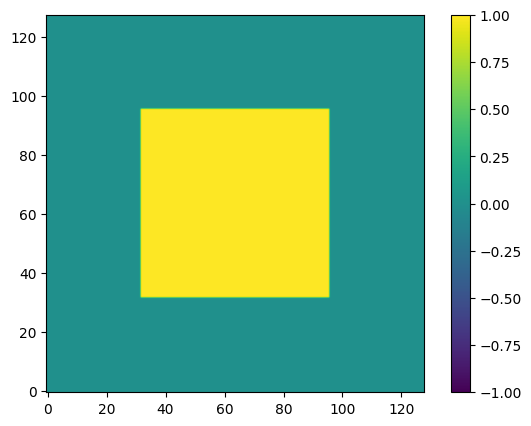

In [6]:
in_field = initialize_field(NX, NY, NZ, mode="square", dim_order="XYZ")
in_field = array_to_gt_storage(in_field, backend=backend, index=(0, 0, 0))
out_field = array_to_gt_storage(in_field, backend=backend, index=(0, 0, 0))
out_field = gt4py_pointwise(in_field, out_field, N_ITER=N_ITER)
plot_field(out_field, dim_order="XYZ")

In [7]:
%%timeit in_field = initialize_field(NX, NY, NZ, mode="square", dim_order="XYZ"); in_field = array_to_gt_storage(in_field, backend=backend, index=(0, 0, 0)); out_field = array_to_gt_storage(in_field, backend=backend, index=(0, 0, 0))
out_field = gt4py_pointwise(in_field, out_field, N_ITER=N_ITER)

49.6 µs ± 321 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


The numpy pointwise copy uses about 60 ms, therefore we see an improvement of over 30% by GT4Py.

In the case above we define origin (starting index) and domain (computation region without halos) manually, like what we've learnt in class. Let's see if the performance changes if we just use the default setting, which is possible in the new GT4Py 1.0.1. This greatly simplify the function and looks much more intuitive.

In [8]:
def gt4py_pointwise_default(in_field, out_field, N_ITER=1):

    for n in range(N_ITER):
        gt4py_pointwise_stencil(
            in_field=in_field,
            out_field=out_field
        )
        
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
        
        return out_field

Here the stencil function is the same as the previous one, so we don't need to compile again.

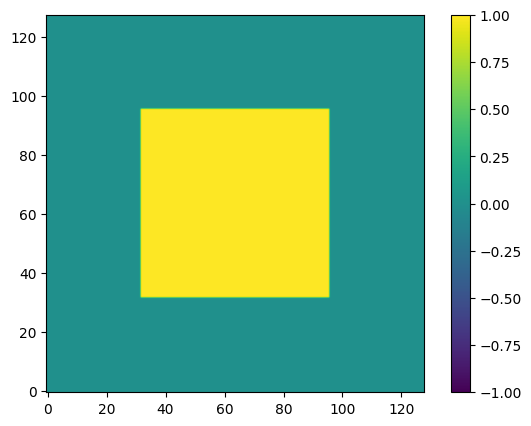

In [9]:
in_field = initialize_field(NX, NY, NZ, mode="square", dim_order="XYZ")
in_field = array_to_gt_storage(in_field, backend=backend, index=(0, 0, 0))
out_field = array_to_gt_storage(in_field, backend=backend, index=(0, 0, 0))
out_field = gt4py_pointwise_default(in_field, out_field, N_ITER=N_ITER)
plot_field(out_field, dim_order="XYZ")

In [10]:
%%timeit in_field = initialize_field(NX, NY, NZ, mode="square", dim_order="XYZ"); in_field = array_to_gt_storage(in_field, backend=backend, index=(0, 0, 0)); out_field = array_to_gt_storage(in_field, backend=backend, index=(0, 0, 0))
out_field = gt4py_pointwise_default(in_field, out_field, N_ITER=N_ITER)

48.8 µs ± 229 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


It seems that in this plain case the index and domain information can be omitted, and GT4Py will find it alone, which has almost no impact on the execution time.

| Function                           | Time    |
|:-----------------------------------|--------:|
| `list_pointwise()`                 |  8.4s   |
| `array_pointwise()`                |  15.3s  |
| `numpy_pointwise()`                |  60.8ms |
| `array_numba_pointwise()`          |  44.9ms |
| `array_numba_parallel_pointwise()` |  11.7ms |
| `numpy_numba_pointwise()`          |  55.9ms |
| `gt4py_pointwise()`                |  39.7ms |
| `gt4py_pointwise_default()`        |  39.7ms |

It's hard to implement Sin function using GT4Py, as functions like math.sin and np.sin cannot be imported inside a stencil, so there will not be any acceleration on sin calculation.

## 1D Stencils

Now we apply GT4Py to 1D stencil calculation. First is columnwise direction. Notice that because of the array sequence for GT4Py is `[x,y,z]` instead of `[z,y,x]`, the plot is rotated by 90&deg;:

###  Same column: $a(i,j) = \frac{1}{2} \Big[b(i+1,j) - b(i,j)\Big]$

In [11]:
def gt4py_1D_same_col_def(
    in_field: gtscript.Field[np.float64],
    out_field: gtscript.Field[np.float64],
):

    from __gtscript__ import PARALLEL, computation, interval
    
    with computation(PARALLEL), interval(...):
        # Apply 1D stencil in gt4py style
        out_field = 0.5 * (in_field[1, 0, 0] - in_field[0, 0, 0])

def gt4py_1D_col(in_field, out_field, N_ITER=1):
    # Define origin and domain for the stencil
    origin = (0, 0, 0)
    nx = in_field.shape[0] - 1
    domain = (
        nx,
        in_field.shape[1],
        in_field.shape[2]
    )
    # Iteration
    for n in range(N_ITER):
        # Update halo value
        in_field[nx, :, :] = in_field[0, :, :]
        
        gt4py_1D_same_col_stencil(
            in_field=in_field,
            out_field=out_field,
            origin=origin,
            domain=domain
        )
        
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
        
    return out_field

In [12]:
backend = "numpy"
gt4py_1D_same_col_stencil = gtscript.stencil(backend=backend, definition=gt4py_1D_same_col_def)

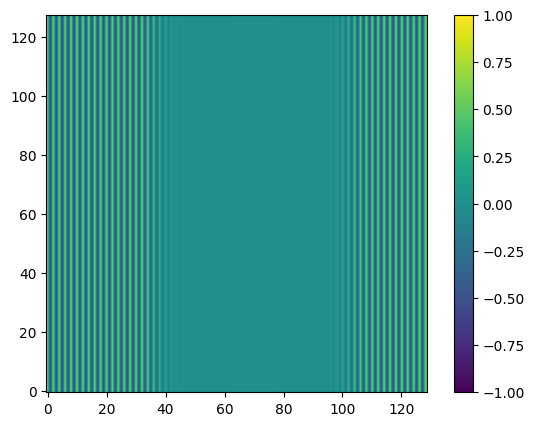

In [13]:
in_field = initialize_field(NX+1, NY, NZ, mode="vertical-bars", array_order="C", dim_order="XYZ")
in_field = array_to_gt_storage(in_field, backend=backend, index=(0, 0, 0))
out_field = array_to_gt_storage(in_field, backend=backend, index=(0, 0, 0))
out_field = gt4py_1D_col(in_field, out_field, N_ITER=N_ITER)
plot_field(out_field, dim_order="XYZ")

In [14]:
%%timeit in_field = initialize_field(NX+1, NY, NZ, mode="vertical-bars", array_order="C", dim_order="XYZ"); in_field = array_to_gt_storage(in_field, backend=backend, index=(0, 0, 0)); out_field = array_to_gt_storage(in_field, backend=backend, index=(0, 0, 0))
out_field = gt4py_1D_col(in_field, out_field, N_ITER=N_ITER)

115 ms ± 884 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


The GT4Py 1D stencil is again about 30% faster than numpy stencil (202 ms). Then we change the memory order of the array (here it's actually `gt.storage` class) to Fortran style to see if the duration change.

In [15]:
%%timeit in_field = initialize_field(NX+1, NY, NZ, mode="vertical-bars", array_order="F", dim_order="XYZ"); in_field = array_to_gt_storage(in_field, backend=backend, index=(0, 0, 0)); out_field = array_to_gt_storage(in_field, backend=backend, index=(0, 0, 0))
out_field = gt4py_1D_col(in_field, out_field, N_ITER=N_ITER)

119 ms ± 2.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


The Fortran-style memory layout boosts GT4Py a little bit. This is not surprising as it's the correct layout for a columnwise computation for GT4Py's `[i,j,k]` dimension sequence. Another interesting thing is to see that the gap between two memory layout styles are relatively small (less than 10%). Other than here by GT4Py, only mumpy row-like methods close this gap perfectly.

| Function                                        | Time   |
|:-----------------------------------------------:|-------:|
| `numpy_1D_same_col_order_C()`                   | 202ms  |
| `numpy_1D_same_col_order_F()`                   | 135ms  |
| `array_numba_parallel_1D_same_col_row_update()` | 58.2ms |
| `array_numba_parallel_1D_same_col_col_update()` | 11.8ms |
| `numpy_numba_1D_same_col_order_C()`             | 194ms  |
| `numpy_numba_1D_same_col_order_F()`             | 638ms  |
| `gt4py_1D_same_col_C()`                         | 153ms  |
| `gt4py_1D_same_col_F()`                         | 142ms  |

Now let's check its performance with rowwise setup:

###  Same row: $a(i,j) = \frac{1}{2} \Big[b(i,j+1) - b(i,j)\Big]$

In [16]:
def gt4py_1D_same_row_def(
    in_field: gtscript.Field[np.float64],
    out_field: gtscript.Field[np.float64],
):

    from __gtscript__ import PARALLEL, computation, interval
    
    with computation(PARALLEL), interval(...):
        # Apply 1D stencil in gt4py style
        out_field = 0.5 * (in_field[0, 1, 0] - in_field[0, 0, 0])

def gt4py_1D_row(in_field, out_field, N_ITER=1):
    # Define origin and domain for the stencil
    origin = (0, 0, 0)
    ny = in_field.shape[1] - 1
    domain = (
        in_field.shape[0],
        ny,
        in_field.shape[2]
    )
    # Iteration
    for n in range(N_ITER):
        # Update halo value
        in_field[:, ny, :] = in_field[:, 0, :]
        
        gt4py_1D_same_row_stencil(
            in_field=in_field,
            out_field=out_field,
            origin=origin,
            domain=domain
        )
        
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
        
    return out_field

In [17]:
backend = "numpy"
gt4py_1D_same_row_stencil = gtscript.stencil(backend=backend, definition=gt4py_1D_same_row_def)

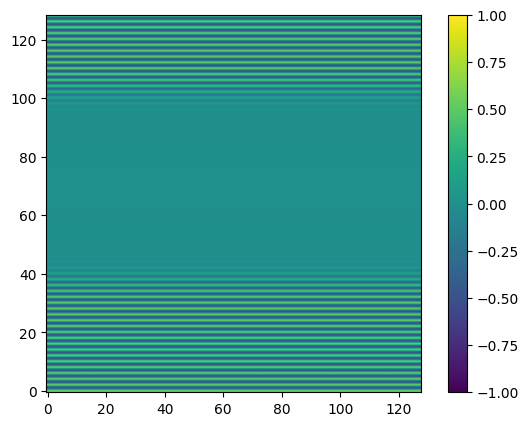

In [18]:
in_field = initialize_field(NX, NY+1, NZ, mode="horizontal-bars", array_order="C", dim_order="XYZ")
in_field = array_to_gt_storage(in_field, backend=backend, index=(0, 0, 0))
out_field = array_to_gt_storage(in_field, backend=backend, index=(0, 0, 0))
out_field = gt4py_1D_row(in_field, out_field, N_ITER=N_ITER)
plot_field(out_field, dim_order="XYZ")

In [19]:
%%timeit in_field = initialize_field(NX+1, NY, NZ, mode="horizontal-bars", array_order="C", dim_order="XYZ"); in_field = array_to_gt_storage(in_field, backend=backend, index=(0, 0, 0)); out_field = array_to_gt_storage(in_field, backend=backend, index=(0, 0, 0))
out_field = gt4py_1D_row(in_field, out_field, N_ITER=N_ITER)

103 ms ± 153 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
%%timeit in_field = initialize_field(NX+1, NY, NZ, mode="horizontal-bars", array_order="F", dim_order="XYZ"); in_field = array_to_gt_storage(in_field, backend=backend, index=(0, 0, 0)); out_field = array_to_gt_storage(in_field, backend=backend, index=(0, 0, 0))
out_field = gt4py_1D_row(in_field, out_field, N_ITER=N_ITER)

104 ms ± 135 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Interestingly, the Fortran-style memory layout is always a bit faster, even though in theory it should be slower for a rowwise stencil. It seems that the GT4Py "numpy" backend makes some specific optimization to a F-style layout.

## 2D stencils
Just like what we've done with Numba, we import functions from the class. As the GT4Py version here is 1.0.1, minor changes have been made.

In [21]:
from stencil2d_gt4py import diffusion_defs, copy_defs

from stencil2d_gt4py import laplacian as laplacian_gt4py
from stencil2d_gt4py import update_halo as update_halo_gt4py
from stencil2d_gt4py import apply_diffusion as apply_diffusion_gt4py

In [22]:
from stencil2d import laplacian, update_halo, apply_diffusion

First we see how the GT4Py laplacian operation performs compared to numpy.

In [23]:
%%timeit in_field = initialize_field(NX, NY, NZ, num_halo=2, mode="square"); out_field = in_field.copy()
laplacian(in_field, out_field, num_halo=2)

7.28 ms ± 6.59 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
%%timeit in_field = initialize_field(NX, NY, NZ, num_halo=2, mode="square", dim_order="XYZ"); in_field = array_to_gt_storage(in_field, backend="numpy", index=(2, 2, 0)); out_field = array_to_gt_storage(in_field, backend="numpy", index=(2, 2, 0))
out_field = laplacian_gt4py(in_field)

845 ns ± 11.1 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [25]:
backend = "numpy"
dtype = np.float64
copy_stencil = gtscript.stencil(
    backend=backend,
    definition=copy_defs, 
    dtypes={"dtype": dtype}
)

diffusion_stencil = gtscript.stencil(
    backend=backend, 
    definition=diffusion_defs,
    dtypes={"dtype": dtype},
    externals={"laplacian": laplacian_gt4py}
)

True

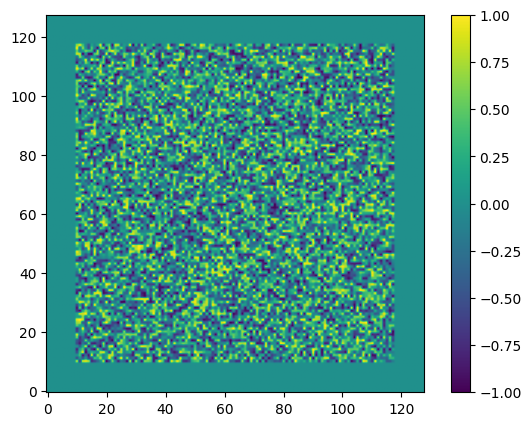

In [26]:
field = initialize_field(NX, NY, NZ, mode="random", num_halo=10, dim_order="XYZ")
field = array_to_gt_storage(field, backend="numpy", index=(10, 10, 0))
copy_field = array_to_gt_storage(field, backend="numpy", index=(10, 10, 0))
plot_field(field, dim_order="XYZ")
np.array_equal(field, copy_field)

False

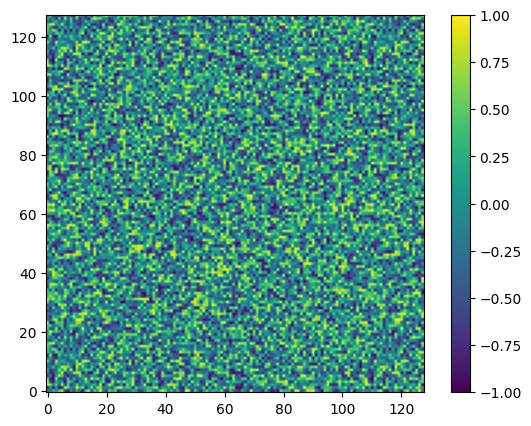

In [27]:
field = np.swapaxes(field, 0, 2)
update_halo(field, num_halo=10)
field = np.swapaxes(field, 0, 2)
plot_field(field, dim_order="XYZ")
np.array_equal(field, copy_field)

True

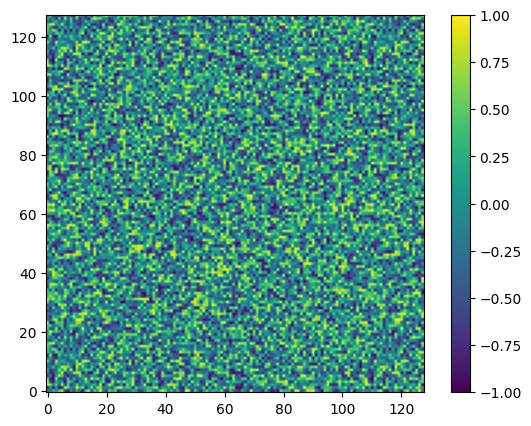

In [28]:
update_halo_gt4py(copy_stencil, copy_field, num_halo=10)
plot_field(copy_field,dim_order="XYZ")
np.array_equal(field, copy_field)

In [29]:
%%timeit field = initialize_field(NX, NY, NZ, mode="random"); copy_field = field.copy()
update_halo(field, num_halo=2)

594 µs ± 5.05 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [30]:
%%timeit field = initialize_field(NX, NY, NZ, mode="random", dim_order="XYZ"); field = array_to_gt_storage(field, backend="numpy", index=(0, 0, 0)); copy_field = array_to_gt_storage(field, backend="numpy", index=(0, 0, 0))
update_halo_gt4py(copy_stencil, field, num_halo=2)

308 µs ± 492 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


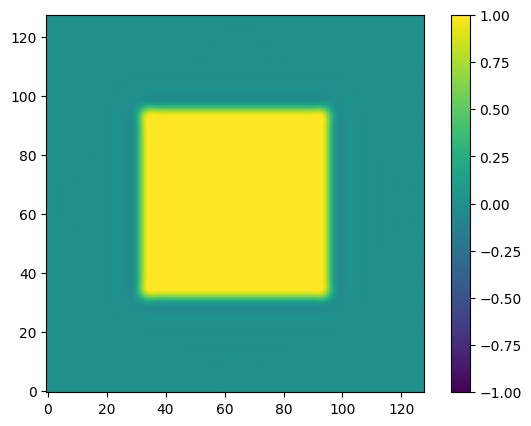

In [31]:
in_field = initialize_field(NX, NY, NZ, mode="square", num_halo=0)
out_field = in_field.copy()
in_field2 = initialize_field(NX, NY, NZ, dim_order="XYZ", mode="square", num_halo=0)
in_field2 = array_to_gt_storage(in_field2, backend="numpy", index=(2, 2, 0))
out_field2 = array_to_gt_storage(in_field2, backend="numpy", index=(2, 2, 0))

apply_diffusion(in_field, out_field, num_halo=2, num_iter=N_ITER)
apply_diffusion_gt4py(diffusion_stencil, copy_stencil, in_field2, out_field2, 1.0/32.0, num_halo=2, num_iter=N_ITER)

out_field2 = np.swapaxes(out_field2, 0, 2)

# There might be small differences (< 1e-7) due to different numerical errors
# Better to test with almost_equal than with np.array_equal()
np.testing.assert_almost_equal(out_field, out_field2)
plot_field(out_field2)

In [32]:
%%timeit in_field = initialize_field(NX, NY, NZ, mode="square"); out_field = in_field.copy()
apply_diffusion(in_field, out_field, num_halo=2, num_iter=N_ITER)

1.05 s ± 2.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
%%timeit in_field = initialize_field(NX, NY, NZ, mode="square", dim_order="XYZ"); in_field = array_to_gt_storage(in_field, backend="numpy", index=(2, 2, 0)); out_field = array_to_gt_storage(in_field, backend="numpy", index=(2, 2, 0))
apply_diffusion_gt4py(diffusion_stencil, copy_stencil, in_field, out_field, 1.0/32.0, num_halo=2, num_iter=N_ITER)

4.54 s ± 649 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Weird maybe?!** Still possible as the backend is "numpy", which may only bring overheads.

## ToDo:
Double check 2D stencil, supplement texts \
Look for Taichi